Data preparation and legacy algorithm implementing

In [1]:
import platform
platform.architecture()

('64bit', '')

In [2]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [93]:
!pip install pycm

In [3]:
!pip install torch

In [4]:
!pip install obspy

In [273]:
!pip install torchvision

     |████████████████████████████████| 2.6MB 426kB/s eta 0:00:01


In [87]:
import os
fileList = os.listdir('/home/chen/Downloads/Data_1106')

In [88]:
print(fileList)

['Inline_3223_DSMF.sgy', 'Xline_1543_class.sgy', 'Inline_3473_class.sgy', 'Xline_1693_class.sgy', 'Xline_1493_class.sgy', 'Inline_3373_class.sgy', 'Inline_3223_class.sgy', 'Inline_3373_DSMF.sgy', 'Inline_3473_DSMF.sgy', 'Xline_1493_DSMF.sgy', 'Xline_1693_DSMF.sgy', 'Xline_1543_DSMF.sgy', 'Inline_3223_DSMF_2.sgy', 'Xline_1693_DSMF_2.sgy', 'Xline_1543_DSMF_2.sgy', 'Xline_1493_DSMF_2.sgy', 'Inline_3373_DSMF_2.sgy', 'Inline_3473_DSMF_2.sgy']


In [274]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print('Running on GPU')
    device = 'cuda'
else:
    print('Running on CPU')

Running on CPU


In [129]:
from obspy.io.segy.segy import _read_segy

stream = _read_segy('/home/chen/Downloads/Data_1106/Inline_3473_DSMF_2.sgy', headonly=True)

In [130]:
stream

1101 traces in the SEG Y structure.

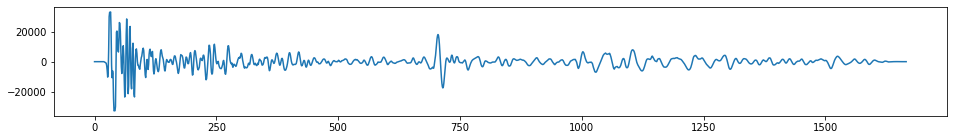

In [131]:
one_trace = stream.traces[0]

plt.figure(figsize=(16,2))
plt.plot(one_trace.data)
plt.show()

In [132]:
stream.traces[0].data.shape

(1667,)

In [133]:
fig1 = []
for i in range(len(stream.traces)):
    fig1.append(stream.traces[i].data)
fig1 = np.array(fig1)
fig1 = fig1.T
print(fig1.shape)

(1667, 1101)


In [134]:
vm = np.percentile(fig1, 99)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm, fig1.max()))

The 99th percentile is 11083; the max amplitude is 35259


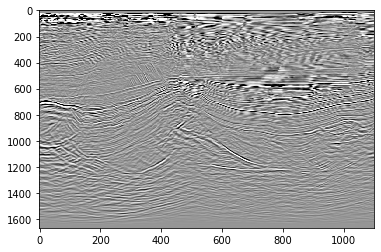

In [135]:

plt.imshow(fig1[:, :], cmap="Greys", vmin=-vm, vmax=vm, aspect='auto')

In [126]:
stream1 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3223_class.sgy', headonly=True)
stream1
figc = []
for i in range(len(stream1.traces)):
    figc.append(stream1.traces[i].data)
figc = np.array(figc)
figc = figc.T
print(figc.shape)

(1667, 1101)


The 99th percentile is 7; the max amplitude is 7


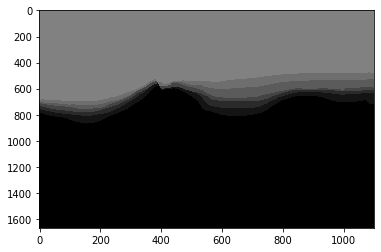

In [128]:
vm1 = np.percentile(figc, 100)
print("The 99th percentile is {:.0f}; the max amplitude is {:.0f}".format(vm1, figc.max()))
plt.imshow(figc, cmap="Greys", vmin=-vm1, vmax=vm1, aspect='auto')

In [169]:
stream1 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3223_DSMF_2.sgy', headonly=True)
stream2 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3373_DSMF_2.sgy', headonly=True)
stream3 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3473_DSMF_2.sgy', headonly=True)
streams = [stream1, stream2, stream3]
fig = []

for stream in streams:
    figtemp = []
    for i in range(len(stream.traces)):
        figtemp.append(stream.traces[i].data)    
    figtemp = np.array(figtemp)
    figtemp = figtemp.T
    fig.append(figtemp)
fig = np.array(fig)
print(fig.shape)

(3, 1667, 1101)


In [170]:
streamc1 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3223_class.sgy', headonly=True)
streamc2 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3373_class.sgy', headonly=True)
streamc3 = _read_segy('/home/chen/Downloads/Data_1106/Inline_3473_class.sgy', headonly=True)
streamcs = [streamc1, streamc2, streamc3]
figc = []

for streamc in streamcs:
    figctemp = []
    for i in range(len(streamc1.traces)):
        figctemp.append(streamc1.traces[i].data)    
    figctemp = np.array(figctemp)
    figctemp = figctemp.T
    figc.append(figctemp)
figc = np.array(figc)
print(figc.shape)

(3, 1667, 1101)


In [343]:
a = fig[1][600:800,600:800]
a = torch.FloatTensor(np.array(a))
a = transformtype(a)
plt.imshow(a)

TypeError: 'list' object is not callable

In [171]:
minib_size = 65
cube_size = 32

In [172]:
def pad_data(fig, minib_size):
    '''crop_size must be a odd number recommend 65'''
    pad_size = minib_size//2

    xconcatb = []
    xconcatm = []

    
    for i in range(pad_size):
        xconcatbtemp = []
        for j in range(2*pad_size + fig.shape[1]):
            xconcatbtemp.append(0.)
        xconcatb.append(xconcatbtemp)    
    
    for i in range(len(fig)):
        xconcatmtemp = []
        for j in range(pad_size):
            xconcatmtemp.append(0.)
        xconcatm.append(xconcatmtemp)
    xconcatm = np.array(xconcatm)

        
    fig = np.concatenate((xconcatm, fig), axis = 1)
    fig = np.concatenate((fig, xconcatm), axis = 1)        
    
    fig = np.concatenate((xconcatb, fig), axis = 0)
    fig = np.concatenate((fig, xconcatb), axis = 0)    
    
    return np.array(fig)

a = pad_data(fig[1], minib_size)

In [173]:
fignew = []
for i in range(len(fig)):
    fignew.append(pad_data(fig[i], minib_size))
fig = np.array(fignew)
print(fig.shape)

(3, 1731, 1165)


In [168]:
#Keep but don't use it

indices = []
labels = []

for i in range(fig.shape[0]):
    for j in range(cube_size, fig.shape[1] - cube_size):
        for k in range(cube_size, fig.shape[2] - cube_size):
            indice = [i , j , k]
            label = figc[i, j-cube_size, k-cube_size]
            indices.append(indice)
            labels.append(label)
indices = np.array(indices)
labels = np.array(labels)
print(indices.shape)
print(labels.shape)

(5506101, 3)
(5506101,)


In [188]:
clss = np.unique(figc) 
sep_indices = []

for n in range(len(clss)):
    sep_indices.append([])
    
for n in range(len(clss)):
    for i in range(fig.shape[0]):
        for j in range(cube_size, fig.shape[1] - cube_size):
            for k in range(cube_size, fig.shape[2] - cube_size):               
                if int(figc[i, j-cube_size, k-cube_size]) == n+1:
                    sep_indices[n].append([i , j , k])

print(len(sep_indices))

7


In [252]:
def data_balancing(sep_indices, num):
    
    for indices in sep_indices:
        n = np.random.randint(0.98 * num, 1.02 * num)
        while len(indices) < n:
            indices.append(indices[np.random.randint(0, len(indices))])
        
        while len(indices) > n: 
            del(indices[np.random.randint(0, len(indices))])  
        
    final_indices = []
    final_labels = []
    
    for i in range(len(sep_indices)):
        for j in range(len(sep_indices[i])):
            final_indices.append(sep_indices[i][j])
            final_labels.append(i)
            
    return np.array(final_indices), np.array(final_labels)

d, j = data_balancing(sep_indices,150000)
print(d.shape)
print(j.shape)

(1050030, 3)
(1050030,)


In [254]:
np.save('indices1306', d)
np.save('labels1306', j)

In [255]:
X_train = np.load('indices1306.npy')
y_train = np.load('labels1306.npy')
print(y_train.shape)

(1050030,)


In [256]:
y_train = torch.LongTensor(y_train)

In [257]:
def normalisation(figs):
    figs = figs.float()
    mean = torch.mean(figs)
    std = torch.std(figs)
    figs -= mean
    figs /= std
    print(mean)
    print(std)
    return figs

In [258]:
seismic = torch.FloatTensor(fig)
seismic = normalisation(seismic)

tensor(15.7457)
tensor(3491.4585)


In [205]:
class MalenovDataset(Dataset):
    def __init__(self, seismic, indices, labels, cube_size):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = indices
        self.labels = labels
        self.count = len(self.labels)
    

    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[idx[0],
                           idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                           idx[2]-self.cube_size:idx[2]+self.cube_size+1]
        label = self.labels[index]
        return (img, label)

 

    def __len__(self):
        return self.count # of how many examples(images?) you have


class MalenovTestDataset(Dataset):
    def __init__(self, seismic, inline, cube_size):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = []
        self.amplitudes = []

        for i in range(self.seismic.shape[2]):
            for j in range(self.seismic.shape[3]):
                if cube_size <= i < seismic.shape[2]-cube_size and cube_size <= j < seismic.shape[3]-cube_size:
                    idx = [inline, i, j]
                    self.indices.append(idx)
                    self.amplitudes.append(self.seismic[:, idx[0], idx[1], idx[2]])
        self.count = len(self.indices)      

    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[:, idx[0]-self.cube_size:idx[0]+self.cube_size+1,
                            idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                            idx[2]-self.cube_size:idx[2]+self.cube_size+1]
        return img
 

    def __len__(self):
        return self.count # of how many examples(images?) you have

In [385]:
class ChenDataset_original(Dataset):
    def __init__(self, seismic, indices, labels, cube_size, prior_transform = None):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = indices
        self.labels = labels
        self.count = len(self.labels)
        self.prior_transform = prior_transform
        self.visit = np.zeros_like(seismic)
    

    def __getitem__(self, index):
        idx = self.indices[index]
        img = self.seismic[idx[0],
                           idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                           idx[2]-self.cube_size:idx[2]+self.cube_size+1]

        if self.visit[idx[0], idx[1], idx[2]] == 0:            
            self.visit[idx[0], idx[1], idx[2]] = 1
        elif self.visit[idx[0], idx[1], idx[2]] == 1:
            img = self.prior_transform(img)[0]
        label = self.labels[index]
        return (img, label)

 

    def __len__(self):
        return self.count # of how many examples(images?) you have
    
    
class ChenDataset_dynamic(Dataset):
    def __init__(self, seismic, indices, labels, cube_size, dynamic_transform = None):
        self.seismic = seismic
        self.cube_size = cube_size
        self.indices = indices
        self.labels = labels
        self.count = len(self.labels)
        self.dynamic_transform = dynamic_transform
    

    def __getitem__(self, index):
        idx = self.indices[index]
        if dynamic_transform:
            img = self.dynamic_transform(self.seismic[idx[0],
                               idx[1]-self.cube_size:idx[1]+self.cube_size+1,
                               idx[2]-self.cube_size:idx[2]+self.cube_size+1])[0] 
        label = self.labels[index]
        return (img, label)

 

    def __len__(self):
        return self.count # of how many examples(images?) you have
    

prior_train_transform = transforms.Compose([transforms.ToPILImage(),
                 transforms.RandomAffine(degrees = 10, translate = (0.05, 0.05)),
                 transforms.ToTensor()])
    
transformtype = [transforms.ToPILImage(),
                 transforms.RandomAffine(degrees = 10, translate = (0.05, 0.05)),
                 transforms.ToTensor()]

dynamic_trian_transform = transforms.RandomApply(transformtype, p = 0.1)

In [382]:
train_dset = ChenDataset_original(seismic, X_train, y_train, cube_size, prior_train_transform)

In [350]:
print(len(train_dset))

1050030


In [292]:
train_dset = MalenovDataset(seismic, X_train, y_train, cube_size)

In [383]:
train_loader = DataLoader(train_dset, shuffle = True, batch_size = 32, num_workers = 4)

In [261]:
class MalenovNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=5, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(50)
        
        self.conv2 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(50)        
        self.drop2 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(50)  
        self.drop3 = nn.Dropout2d(0.2)
            
        self.conv4 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(50)          
        self.drop4 = nn.Dropout2d(0.2)
        
        self.conv5 = nn.Conv2d(50, 50, kernel_size=3, stride=2, padding=1)  
        
        self.linear1 = nn.Linear(200, 50)
        self.bn_ln1 = nn.BatchNorm1d(50)
        self.linear2 = nn.Linear(50, 10)
        self.bn_ln2 = nn.BatchNorm1d(10)
        
        self.logits = nn.Linear(10, 7)
        self.bn_logits = nn.BatchNorm1d(7)
        
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.drop2(self.conv2(x))))
        x = F.relu(self.bn3(self.drop3(self.conv3(x))))   
        x = F.relu(self.bn4(self.drop4(self.conv4(x)))) 
        x = self.conv5(x)
        x = x.view(-1, 200)
        x = F.relu(self.bn_ln1(self.linear1(x)))
        x = F.relu(self.bn_ln2(self.linear2(x)))
        logits = self.bn_logits(self.logits(x))
        return logits

In [262]:
lr = 1e-2
mom = 0.05
batch_size = 32
test_batch_size = 1000
n_epochs = 80
w_decay = 0.0

In [265]:
def train(model, optimizer, criterion, data_loader, minib_size):
    model.train() # train model mode
    train_loss, train_accuracy = 0, 0 #instantiate return variables
    for X, y in data_loader: #iterate over data in batch size
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X.view(X.size(0), 1, minib_size, minib_size)).to(device) # predict for current data the model(x) value
        loss = criterion(a2, y.long()) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0) # check for accuracy
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    model.eval() #model evaluation
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad(): # no optimisierr or stepping
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(X.size(0), 1, minib_size, minib_size)).to(device) # predict for current data the model(x) value
            loss = criterion(a2, y.long()) #compute the loss by computing the criterion(y_prediction, y_real)
            validation_loss += loss*X.size(0)# keep track of loss
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0) # check and track accuracy
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)


In [333]:
model = MalenovNet()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas = (0.9, 0.999), eps = 1e-08, weight_decay = w_decay)

Normal Training

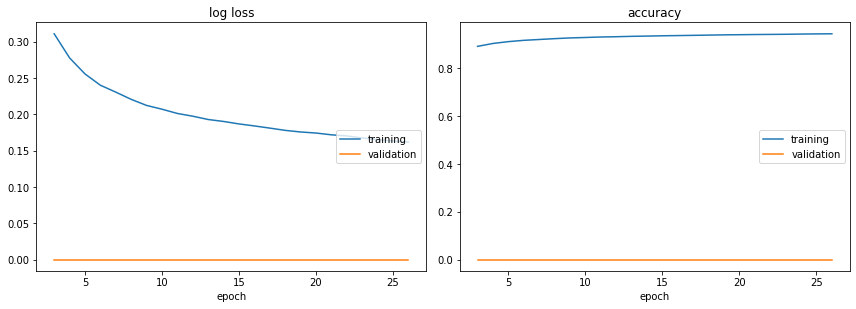

log loss:
training   (min:    0.162, max:    0.602, cur:    0.162)
validation (min:    0.000, max:    0.000, cur:    0.000)

accuracy:
training   (min:    0.779, max:    0.944, cur:    0.944)
validation (min:    0.000, max:    0.000, cur:    0.000)


KeyboardInterrupt: 

In [266]:
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    liveloss.update(logs)
    liveloss.draw()

Dynamic Training

In [384]:
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader, minib_size)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    liveloss.update(logs)
    liveloss.draw()
    
    train_dset = ChenDataset_dynamic(seismic, X_train, y_train, cube_size, dynamic_train_transform)
    train_loader = DataLoader(train_dset, shuffle = True, batch_size = 32, num_workers = 4)

[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.84313726,  0.8862745 ,
        0.9411765 ,  0.95686275,  0.89411765,  0.7411765 ,  0.40784314,
        0.9843137 ,  0.7490196 ,  0.45882353,  0.37254903,  0.43137255,
        0.54901963,  0.80784315,  0.15294118,  0.5411765 ,  0.92941177,
        0.24705882,  0.59607846,  0.89411765,  0.16862746,  0.46666667,
        0.74509805,  0.99607843,  0.3019608 ,  0.5254902 ,  0.69803923,
        0.8352941 ,  0.9529412 ,  0.02745098,  0.10980392,  0.1764706 ,
        0.3019608 ,  0.25490198,  0.16470589,  0.04705882,  0.92941177,
        0.7529412 ,  0.54901963,  0.3372549 ,  0.23137255,  0.03137255,
        0.81960785,  0.6745098 ,  0.5882353 ,  0.5686275 ,  0.6313726 ,
        0.7529412 ,  0.06666667,  0.4509804 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32), array([ 0.12156863,  0.21176471,  0.33333334, 

        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)]
[array([ 0.        ,  0.9843137 ,  0.30588236,  0.5058824 ,  0.91764706,
        0.94509804,  0.02352941,  0.45490196,  0.84705883,  0.6       ,
        0.10196079,  0.7019608 ,  0.6       ,  0.7058824 ,  0.4862745 ,
        0.7490196 ,  0.34117648,  0.07058824,  0.35686275,  0.3647059 ,
        0.36078432,  0.6       ,  0.3529412 ,  0.8980392 ,  0.60784316,
        0.8666667 ,  0.8117647 ,  0.54901963,  0.4627451 ,  0.5176471 ,
        0.60784316,  0.6509804 ,  0.6666667 ,  0.7176471 ,  0.827451  ,
        0.9490196 ,  0.10196079,  0.33333334,  0.6313726 ,  0.5803922 ,
        0.38431373,  0.30980393,  0.20784314,  0.40392157,  0.32941177,
        0.23137255,  0.1254902 ,  0.15294118,  0.14509805,  0.09411765,
        0.94509804,  1.        ,  0.16078432,  0.24313726,  0.22352941,
        0.18431373,  0.07450981,  0.9411765 ,  0.26666668,  0.38039216,
        0.47843137,  0.38039216,  0.07843138, 

        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)]
[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32), array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.      

        0.34117648,  0.38039216,  0.49019608,  0.69411767,  0.01568628], dtype=float32)]
[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.5882353 ,  0.5686275 ,  0.54901963,  0.05882353,  0.00784314,
        0.9647059 ,  0.94509804,  0.93333334,  0.8980392 ,  0.6509804 ,
        0.654902  ,  0.6509804 ,  0.63529414,  0.5882353 ,  0.5686275 ,
        0.32941177,  0.36862746,  0.40784314,  0.40392157,  0.36078432,
        0.28235295,  0.8039216 ,  0.7921569 ,  0.76862746,  0.7254902 ,
        0.6784314 ,  0.6431373 ,  0.05490196,  0.05490196,  0.04705882,
        0.01960784,  1.        ,  0.96862745,  0.92156863,  0.19607843,
        0.18431373,  0.17254902,  0.13725491,  0.06666667,  0.99215686,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 

        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)]
[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.00784314,
        0.00392157,  0.00392157,  0.05098039,  0.03921569,  0.03137255,
        0.00392157,  0.99215686,  0.9490196 ,  0.6901961 ,  0.61960787,
        0.5294118 ,  0.47843137,  0.39607844,  0.30588236,  0.15294118,
        0.13725491,  0.09411765,  0.05490196,  0.02745098,  0.9882353 ,
        0.18431373,  0.34117648,  0.3764706 ,  0.36862746,  0.32941177,
        0.29411766,  0.24313726,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 

        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)]
[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.3137255 ,  0.32156864,  0.34117648,  0.37254903,
        0.40784314,  0.43137255,  0.5058824 ,  0.53333336,  0.50980395,
        0.5019608 ,  0.6039216 ,  0.69803923,  0.8392157 ,  0.04313726,
        0.04313726,  0.08235294,  0.15294118,  0.27058825,  0.3647059 ,
        0.4       ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 

        0.21960784,  0.20392157,  0.        ,  0.        ,  0.        ], dtype=float32)]
[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.35686275,  0.        ,  0.        , 

        0.13725491,  0.95686275,  0.62352943,  0.9764706 ,  0.52156866], dtype=float32)]
[array([ 0.        ,  0.01568628,  0.9490196 ,  0.85490197,  0.76862746,
        0.7019608 ,  0.62352943,  0.13725491,  0.02352941,  0.9372549 ,
        0.8784314 ,  0.8666667 ,  0.8784314 ,  0.87058824,  0.827451  ,
        0.7647059 ,  0.69803923,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 

        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)][array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.29803923,
        0.35686275,  0.4       ,  0.98039216,  0.01960784,  0.07058824,
        0.13333334,  0.19607843,  0.2784314 ,  0.3647059 ,  0.64705884,
        0.68235296,  0.7058824 ,  0.74509805,  0.8235294 ,  0.88235295,
        0.89411765,  0.9647059 ,  1.        ,  0.        ,  0.00784314,
        0.00392157,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  

        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)]

[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.8352941 ,  0.2901961 ,  0.38039216,
        0.972549  ,  0.48235294,  0.05490196,  0.7137255 ,  0.3764706 ,
        0.01960784,  0.36862746,  0.01960784,  0.64705884,  0.64705884,
        0.23529412,  0.79607844,  0.972549  ,  0.40392157,  0.85882354,
        0.3882353 ,  0.14509805,  0.19215687,  0.4627451 ,  0.22352941,
        0.50980395,  0.12156863,  0.92941177,  0.4392157 ,  0.7176471 ,
        0.5647059 ,  0.7529412 ,  0.75686276,  0.56078434,  0.1882353 ,
        0.7411765 ,  0.3019608 ,  0.29803923,  0.1254902 ,  0.10588235,
        0.10588235,  0.5529412 ,  0.77254903,  0.09019608,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,

        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.], dtype=float32)]


KeyboardInterrupt: 

In [267]:
model_save_name = 'firsttry.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [ ]:
class LegacyNet(nn.Module):
    def __init__(self, minib_size):
        super(LegacyNet, self).__init__()
        self.linear1 = nn.Linear(minib_size * minib_size, 7)
        self.batchnorm = nn.Batchnorm1d(minib_size * minib_size / 2)
        
    def forward(self, x):
        z1 = self.linear1(x)
        a1 = self.batchnorm(z1)
        return a1

## Exercise results

In [2]:
import xlrd

In [40]:
data1 = xlrd.open_workbook('Exercices.xlsx')

In [41]:
sheetname = 'Exo01_ResB'
table = data1.sheet_by_name(sheetname)
nrows = table.nrows
ncols = table.ncols
attB = []
poB = []
PHIB = []

for i in range(2, nrows):
    rowV = table.row_values(i)
    att = []
    po = []
    PHI = []
    for j in range(3, 13):
        att.append(rowV[j])
    for k in range(13, 33):
        po.append(rowV[k])
    for m in range(33, 53):
        PHI.append(rowV[m])
    attB.append(att)
    poB.append(np.mean(np.array(po)))
    PHIB.append(np.mean(np.array(PHI)))

print(len(attB))
print(len(attB[0]))
    

5183
10


In [42]:
x_data = Variable(torch.from_numpy(np.array(attB))).float()
y_data_po = Variable(torch.from_numpy(np.array(poB))).float()
y_data_PHI = Variable(torch.from_numpy(np.array(PHIB))).float()

In [43]:
train_x_data = x_data[:4000]
train_po_data = y_data_po[:4000]
train_PHI_data = y_data_PHI[:4000]

val_x_data = x_data[4000:4500]
val_po_data = x_data[4000:4500]
val_pHI_data = x_data[4000:4500]

test_x_data = x_data[4500:]
test_po_data = x_data[4500:]
test_pHI_data = x_data[4500:]

In [44]:
print(train_x_data[1])

tensor([-1042.1801,  1080.5500,  1166.8900,   739.8500,   847.1700,  -514.0800,
          509.9900,   -92.0500,   840.5000,  -303.3100])


In [51]:
print(train_po_data)

tensor([32.0000, 25.5000, 30.5000,  ..., 28.7500, 31.5000, 31.7500])


In [45]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.l1 = nn.Linear(10,6)
        self.l2 = nn.Linear(6,4)
        self.l3 = nn.Linear(4,1)
        
    def forward(self,x):
        x = self.l1(x)
        x = self.l2(x)
        y_pred = self.l3(x)
        return y_pred

In [46]:
def train(model, optimizer, criterion, x_train, y_train):
    model.train() # train model mode
    train_loss = 0. #instantiate return variables
    for i in range(len(x_train)): #iterate over data in batch size
        X, y = x_train[i].to(device), y_train[i].to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X).to(device) # predict for current data the model(x) value
        loss = criterion(a2, y) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = a2 # apply softmax layer to prediction
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(x_train)
  
def validate(model, criterion, x_val, y_val):
    model.eval() #model evaluation
    validation_loss = 0.
    for i in range(len(x_val)):
        with torch.no_grad(): # no optimisierr or stepping
            X, y = x_val[i].to(device), y_val[i].to(device)
            a2 = model(X).to(device) # predict for current data the model(x) value
            loss = criterion(a2, y) #compute the loss by computing the criterion(y_prediction, y_real)
            validation_loss += loss*X.size(0)# keep track of loss
            y_pred = a2
            
    return validation_loss/len(x_val)

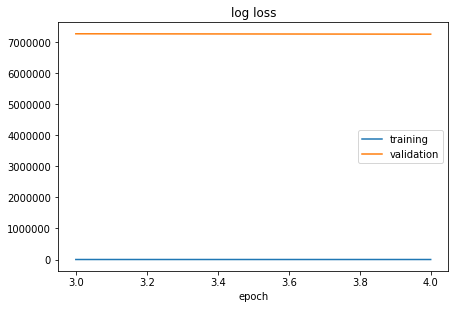

log loss:
training   (min: 1832.040, max: 15947.987, cur: 1832.040)
validation (min: 7254227.500, max: 7277280.500, cur: 7254227.500)


KeyboardInterrupt: 

In [48]:
model = Model1()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0
liveloss = PlotLosses()

for epoch in range(100):
    logs = {}
    train_loss = train(model, optimizer, criterion, train_x_data, train_po_data) #train model using training data loader
    logs['' + 'log loss'] = train_loss.item()
    #logs['' + 'accuracy'] = 0

    validation_loss = validate(model, criterion, val_x_data, val_po_data) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    #logs['val_' + 'accuracy'] = 0

    liveloss.update(logs)
    liveloss.draw() ## plote LiveLoss plot

print(ite)
print(model.forward(t_var).data[0])

In [354]:
for param in model.parameters():
    print(param.data)

tensor([[-0.5087, -0.0582, -0.1385, -1.1502,  0.0718,  0.2381, -0.0690,  1.6658,
          0.4977, -1.3117],
        [-0.5047,  0.0391, -0.0042, -1.3406,  0.0318,  0.1815,  0.3239,  1.9705,
         -0.1123, -1.6754],
        [-0.0853,  0.2117, -0.0140, -0.7154,  0.0516,  0.0198,  0.5445,  1.3675,
         -0.5068, -1.4400],
        [-0.1453,  0.0882,  0.1230, -0.8540, -0.1577,  0.1574,  0.5281,  1.9320,
         -0.3510, -1.8031],
        [-0.1958,  0.0802,  0.2791, -1.0500, -0.2822, -0.1407,  0.5053,  1.8549,
         -0.3158, -1.4369],
        [-0.3353, -0.2769, -0.0509, -0.5694,  0.1054,  0.0852, -0.1700,  1.0290,
          0.6005, -0.2315]])
tensor([-1.9285, -0.2956,  3.2255,  1.9462,  1.7986, -1.4054])
tensor([[ 0.0371,  0.0070,  0.0152,  0.0198,  0.0171,  0.0111],
        [-0.0216, -0.0241, -0.0189,  0.0058,  0.0072, -0.0284],
        [-0.0315, -0.0418, -0.0086,  0.0288, -0.0696, -0.0158],
        [-0.0168,  0.0164, -0.0151, -0.0095,  0.0200,  0.0115]])
tensor([  9.7125,  10.515

In [282]:
model = Model()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0

for epoch in range(1000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data_po)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    if len(result_n) > 50 and abs(new_result - result_n[-40]) < 0.1:
        break
    print(model.forward(t_var).data[0])

print(ite)
print(model.forward(t_var).data[0])

tensor(-97.4239)
tensor(-90.2412)
tensor(-83.2009)
tensor(-76.3102)
tensor(-69.5736)
tensor(-62.9931)
tensor(-56.5678)
tensor(-50.2941)
tensor(-44.1666)
tensor(-38.1788)
tensor(-32.3245)
tensor(-26.5983)
tensor(-20.9963)
tensor(-15.5163)
tensor(-10.1580)
tensor(-4.9232)
tensor(0.1844)
tensor(5.1592)
tensor(9.9936)
tensor(14.6781)
tensor(19.2016)
tensor(23.5511)
tensor(27.7125)
tensor(31.6701)
tensor(35.4074)
tensor(38.9073)
tensor(42.1529)
tensor(45.1276)
tensor(47.8166)
tensor(50.2072)
tensor(52.2895)
tensor(54.0578)
tensor(55.5100)
tensor(56.6489)
tensor(57.4816)
tensor(58.0193)
tensor(58.2775)
tensor(58.2743)
tensor(58.0310)
tensor(57.5707)
tensor(56.9177)
tensor(56.0972)
tensor(55.1345)
tensor(54.0546)
tensor(52.8815)
tensor(51.6385)
tensor(50.3473)
tensor(49.0281)
tensor(47.6994)
tensor(46.3780)
tensor(45.0787)
tensor(43.8147)
tensor(42.5971)
tensor(41.4356)
tensor(40.3379)
tensor(39.3102)
tensor(38.3575)
tensor(37.4829)
tensor(36.6887)
tensor(35.9756)
tensor(35.3437)
tensor(34.79

tensor(24.7920)
tensor(24.7925)
tensor(24.7930)
tensor(24.7934)
tensor(24.7939)
tensor(24.7944)
tensor(24.7949)
tensor(24.7954)
tensor(24.7959)
tensor(24.7964)
tensor(24.7969)
tensor(24.7974)
tensor(24.7980)
tensor(24.7985)
tensor(24.7990)
tensor(24.7995)
tensor(24.8000)
tensor(24.8006)
tensor(24.8011)
tensor(24.8016)
tensor(24.8022)
tensor(24.8027)
tensor(24.8032)
tensor(24.8038)
tensor(24.8043)
tensor(24.8049)
tensor(24.8054)
tensor(24.8060)
tensor(24.8065)
tensor(24.8071)
tensor(24.8076)
tensor(24.8082)
tensor(24.8087)
tensor(24.8093)
tensor(24.8099)
tensor(24.8104)
tensor(24.8110)
tensor(24.8116)
tensor(24.8121)
tensor(24.8127)
tensor(24.8133)
tensor(24.8139)
tensor(24.8144)
tensor(24.8150)
tensor(24.8156)
tensor(24.8162)
tensor(24.8168)
tensor(24.8173)
tensor(24.8179)
tensor(24.8185)
tensor(24.8191)
tensor(24.8197)
tensor(24.8202)
tensor(24.8208)
tensor(24.8214)
tensor(24.8219)
tensor(24.8225)
tensor(24.8231)
tensor(24.8237)
tensor(24.8243)
tensor(24.8249)
tensor(24.8255)
tensor(2

In [283]:
model_save_name = 'net1po.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [286]:
print(train_PHI_data[0])

tensor(0.0231)


In [47]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1,self).__init__()
        self.l1 = nn.Linear(10,6)
        self.l2 = nn.Linear(6,4)
        self.l3 = nn.Linear(4,1)
        self.dropout = nn.Dropout()
        
    def forward(self,x):
        x = self.dropout(self.l1(x))
        x = self.dropout(self.l2(x))
        y_pred = self.l3(x)
        return y_pred

In [288]:
model = Model()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.01, betas = (0.8, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0

for epoch in range(10000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data_PHI)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    result_n.append(new_result)
    ite += 1
    #if len(result_n) > 50 and abs(new_result - result_n[-40]) < 0.1:
    #    break

#print(ite)
    if ite % 100 == 0:
        print(model.forward(t_var).data[0])

tensor(-2.5565)
tensor(-1.3456)
tensor(-1.0975)
tensor(-0.9331)
tensor(-0.7944)
tensor(-0.6878)
tensor(-0.6096)
tensor(-0.5513)
tensor(-0.5048)
tensor(-0.4641)
tensor(-0.4256)
tensor(-0.3870)
tensor(-0.3473)
tensor(-0.3063)
tensor(-0.2638)
tensor(-0.2201)
tensor(-0.1755)
tensor(-0.1303)
tensor(-0.0850)
tensor(-0.0401)
tensor(0.0040)
tensor(0.0465)
tensor(0.0870)
tensor(0.1247)
tensor(0.1592)
tensor(0.1898)
tensor(-1.3074)
tensor(-2.0999)
tensor(-0.2580)
tensor(0.2334)
tensor(1.2041)
tensor(0.2351)
tensor(0.2499)
tensor(0.2293)
tensor(0.2340)
tensor(0.2517)
tensor(0.2224)
tensor(0.2238)
tensor(0.3819)
tensor(0.2092)
tensor(0.2101)
tensor(0.1919)
tensor(0.1932)
tensor(0.1934)
tensor(0.2087)
tensor(0.1777)
tensor(0.1778)
tensor(0.1687)
tensor(0.1626)
tensor(0.3579)
tensor(0.1479)
tensor(-0.5141)
tensor(0.1342)
tensor(0.1355)
tensor(0.1365)
tensor(0.2428)
tensor(0.1227)
tensor(0.1227)
tensor(0.1107)
tensor(0.1101)
tensor(0.1116)
tensor(-0.0150)
tensor(0.0978)
tensor(0.0997)
tensor(1.7494)


In [289]:
model_save_name = 'net1PHIE.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [303]:
model = Model()
model.load_state_dict(torch.load(path))
model.eval()

Model(
  (l1): Linear(in_features=10, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [304]:
criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.001, betas = (0.8, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([-1129.62, 1313.33, 1343.06, 772.17, 976.16, -532.51, 572.33, -121.68, 970.52, -356.75
]))

result_n = []
ite = 0
gap = 0
ref = 0.0003
cnt = 0

for epoch in range(10000):
    y_pred = model(x_data)
    loss = criterion(y_pred, y_data)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    result_n.append(new_result)
    if len(result_n) > 3:
        gap = abs(new_result - result_n[-2])
        if gap <= ref:
            cnt += 1
            if cnt >= 500:
                break
        else:
            cnt = 0
    ite += 1
    

#print(ite)
    if ite % 100 == 0:
        print(model.forward(t_var).data[0])

tensor(0.0244)
tensor(0.0251)
tensor(0.0254)
tensor(0.0257)
tensor(0.0259)


In [305]:
model_save_name = 'net1PHIE.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [318]:
sheetname1 = 'Exo01_ResN'
table1 = data1.sheet_by_name(sheetname1)
nrows1 = table1.nrows
ncols1 = table1.ncols
attB1 = []
poB1 = []
PHIB1 = []

for i in range(1, nrows1-4):
    rowV = table1.row_values(i)
    att = []
    po = []
    PHI = []
    for j in range(3, 13):
        att.append(rowV[j])
    for k in range(13, 33):
        po.append(rowV[k])
    for m in range(33, 53):
        PHI.append(rowV[m])
    attB1.append(att)
    poB1.append(np.array([np.mean(np.array(po))]))
    PHIB1.append(np.array([np.mean(np.array(PHI))]))

print(len(attB1))
print(len(attB1[0]))

5184
10


In [319]:
x_data1 = Variable(torch.from_numpy(np.array(attB1))).float()
y_data_po1 = Variable(torch.from_numpy(np.array(poB1))).float()
y_data_PHI1 = Variable(torch.from_numpy(np.array(PHIB1))).float()

In [320]:
print(y_data_po1)

tensor([[13.3325],
        [12.9995],
        [12.0010],
        ...,
        [ 9.6675],
        [ 9.5010],
        [ 8.0005]])


In [323]:
model = Model()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([732.51, 1310.87, 597.62, 892.79, -366.94, 292.36, 453.83, 415.73, 132.72, -465.42]))

result_n = []
ite = 0

for epoch in range(3000):
    y_pred = model(x_data1)
    #print(y_pred)
    loss = criterion(y_pred, y_data_po1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    ite += 1
    if len(result_n) > 50 and abs(new_result - result_n[-40]) < 0.1:
        break
    print(model.forward(t_var).data[0])

print(ite)
print(model.forward(t_var).data[0])

tensor(25.0583)
tensor(23.8366)
tensor(21.9165)
tensor(19.6693)
tensor(17.3229)
tensor(15.0485)
tensor(12.9957)
tensor(11.2403)
tensor(9.7648)
tensor(8.5071)
tensor(7.3980)
tensor(6.3777)
tensor(5.4054)
tensor(4.4681)
tensor(3.5802)
tensor(2.7768)
tensor(2.1014)
tensor(1.5915)
tensor(1.2683)
tensor(1.1326)
tensor(1.1689)
tensor(1.3504)
tensor(1.6447)
tensor(2.0179)
tensor(2.4387)
tensor(2.8828)
tensor(3.3359)
tensor(3.7936)
tensor(4.2599)
tensor(4.7428)
tensor(5.2493)
tensor(5.7816)
tensor(6.3349)
tensor(6.8971)
tensor(7.4500)
tensor(7.9733)
tensor(8.4478)
tensor(8.8596)
tensor(9.2028)
tensor(9.4796)
tensor(9.6993)
tensor(9.8740)
tensor(10.0158)
tensor(10.1330)
tensor(10.2288)
tensor(10.3014)
tensor(10.3456)
tensor(10.3558)
tensor(10.3287)
tensor(10.2654)
tensor(10.1721)
tensor(10.0591)
tensor(9.9385)
tensor(9.8219)
tensor(9.7179)
tensor(9.6309)
tensor(9.5607)
tensor(9.5045)
tensor(9.4583)
tensor(9.4191)
tensor(9.3862)
tensor(9.3621)
tensor(9.3510)
tensor(9.3576)
tensor(9.3858)
tensor(

tensor(14.6056)
tensor(14.6098)
tensor(14.6140)
tensor(14.6182)
tensor(14.6224)
tensor(14.6266)
tensor(14.6308)
tensor(14.6350)
tensor(14.6392)
tensor(14.6435)
tensor(14.6477)
tensor(14.6519)
tensor(14.6561)
tensor(14.6603)
tensor(14.6645)
tensor(14.6687)
tensor(14.6729)
tensor(14.6771)
tensor(14.6814)
tensor(14.6856)
tensor(14.6898)
tensor(14.6940)
tensor(14.6982)
tensor(14.7024)
tensor(14.7066)
tensor(14.7109)
tensor(14.7151)
tensor(14.7193)
tensor(14.7235)
tensor(14.7277)
tensor(14.7320)
tensor(14.7362)
tensor(14.7404)
tensor(14.7446)
tensor(14.7489)
tensor(14.7531)
tensor(14.7573)
tensor(14.7615)
tensor(14.7658)
tensor(14.7700)
tensor(14.7742)
tensor(14.7784)
tensor(14.7827)
tensor(14.7869)
tensor(14.7911)
tensor(14.7954)
tensor(14.7996)
tensor(14.8038)
tensor(14.8081)
tensor(14.8123)
tensor(14.8166)
tensor(14.8208)
tensor(14.8250)
tensor(14.8293)
tensor(14.8335)
tensor(14.8378)
tensor(14.8420)
tensor(14.8463)
tensor(14.8505)
tensor(14.8548)
tensor(14.8590)
tensor(14.8633)
tensor(1

tensor(17.2933)
tensor(17.2992)
tensor(17.3051)
tensor(17.3110)
tensor(17.3170)
tensor(17.3229)
tensor(17.3287)
tensor(17.3347)
tensor(17.3406)
tensor(17.3464)
tensor(17.3523)
tensor(17.3583)
tensor(17.3642)
tensor(17.3700)
tensor(17.3759)
tensor(17.3818)
tensor(17.3877)
tensor(17.3936)
tensor(17.3994)
tensor(17.4053)
tensor(17.4112)
tensor(17.4170)
tensor(17.4230)
tensor(17.4288)
tensor(17.4347)
tensor(17.4405)
tensor(17.4464)
tensor(17.4523)
tensor(17.4581)
tensor(17.4639)
tensor(17.4698)
tensor(17.4756)
tensor(17.4814)
tensor(17.4873)
tensor(17.4931)
tensor(17.4989)
tensor(17.5047)
tensor(17.5106)
tensor(17.5164)
tensor(17.5222)
tensor(17.5280)
tensor(17.5338)
tensor(17.5396)
tensor(17.5454)
tensor(17.5512)
tensor(17.5569)
tensor(17.5627)
tensor(17.5685)
tensor(17.5742)
tensor(17.5800)
tensor(17.5857)
tensor(17.5915)
tensor(17.5972)
tensor(17.6030)
tensor(17.6087)
tensor(17.6145)
tensor(17.6201)
tensor(17.6259)
tensor(17.6316)
tensor(17.6373)
tensor(17.6430)
tensor(17.6487)
tensor(1

tensor(19.0231)
tensor(19.0240)
tensor(19.0241)
tensor(19.0253)
tensor(19.0253)
tensor(19.0264)
tensor(19.0266)
tensor(19.0275)
tensor(19.0280)
tensor(19.0285)
tensor(19.0293)
tensor(19.0295)
tensor(19.0305)
tensor(19.0307)
tensor(19.0316)
tensor(19.0319)
tensor(19.0327)
tensor(19.0332)
tensor(19.0337)
tensor(19.0344)
tensor(19.0348)
tensor(19.0355)
tensor(19.0359)
tensor(19.0366)
tensor(19.0370)
tensor(19.0376)
tensor(19.0381)
tensor(19.0387)
tensor(19.0392)
tensor(19.0397)
tensor(19.0403)
tensor(19.0408)
tensor(19.0413)
tensor(19.0418)
tensor(19.0424)
tensor(19.0429)
tensor(19.0434)
tensor(19.0439)
tensor(19.0444)
tensor(19.0450)
tensor(19.0454)
tensor(19.0459)
tensor(19.0464)
tensor(19.0470)
tensor(19.0474)
tensor(19.0479)
tensor(19.0484)
tensor(19.0489)
tensor(19.0494)
tensor(19.0499)
tensor(19.0504)
tensor(19.0508)
tensor(19.0513)
tensor(19.0518)
tensor(19.0523)
tensor(19.0527)
tensor(19.0532)
tensor(19.0536)
tensor(19.0542)
tensor(19.0545)
tensor(19.0551)
tensor(19.0555)
tensor(1

tensor(19.1774)
tensor(19.1527)
tensor(19.1774)
tensor(19.1592)
tensor(19.1677)
tensor(19.1704)
tensor(19.1587)
tensor(19.1763)
tensor(19.1580)
tensor(19.1733)
tensor(19.1647)
tensor(19.1658)
tensor(19.1722)
tensor(19.1609)
tensor(19.1745)
tensor(19.1623)
tensor(19.1712)
tensor(19.1677)
tensor(19.1661)
tensor(19.1725)
tensor(19.1636)
tensor(19.1734)
tensor(19.1653)
tensor(19.1708)
tensor(19.1693)
tensor(19.1674)
tensor(19.1725)
tensor(19.1661)
tensor(19.1730)
tensor(19.1674)
tensor(19.1712)
tensor(19.1702)
tensor(19.1690)
tensor(19.1725)
tensor(19.1681)
tensor(19.1730)
tensor(19.1689)
tensor(19.1721)
tensor(19.1708)
tensor(19.1706)
tensor(19.1726)
tensor(19.1698)
tensor(19.1733)
tensor(19.1702)
tensor(19.1730)
tensor(19.1714)
tensor(19.1721)
tensor(19.1728)
tensor(19.1714)
tensor(19.1736)
tensor(19.1714)
tensor(19.1738)
tensor(19.1721)
tensor(19.1734)
tensor(19.1731)
tensor(19.1729)
tensor(19.1739)
tensor(19.1728)
tensor(19.1744)
tensor(19.1730)
tensor(19.1744)
tensor(19.1736)
tensor(1

tensor(19.2102)
tensor(19.2100)
tensor(19.2102)
tensor(19.2103)
tensor(19.2102)
tensor(19.2106)
tensor(19.2103)
tensor(19.2108)
tensor(19.2105)
tensor(19.2109)
tensor(19.2107)
tensor(19.2110)
tensor(19.2110)
tensor(19.2111)
tensor(19.2112)
tensor(19.2112)
tensor(19.2114)
tensor(19.2113)
tensor(19.2116)
tensor(19.2114)
tensor(19.2117)
tensor(19.2116)
tensor(19.2118)
tensor(19.2118)
tensor(19.2120)
tensor(19.2120)
tensor(19.2121)
tensor(19.2122)
tensor(19.2122)
tensor(19.2124)
tensor(19.2123)
tensor(19.2125)
tensor(19.2125)
tensor(19.2127)
tensor(19.2126)
tensor(19.2128)
tensor(19.2128)
tensor(19.2129)
tensor(19.2130)
tensor(19.2131)
tensor(19.2131)
tensor(19.2132)
tensor(19.2133)
tensor(19.2133)
tensor(19.2134)
tensor(19.2134)
tensor(19.2136)
tensor(19.2136)
tensor(19.2138)
tensor(19.2137)
tensor(19.2139)
tensor(19.2138)
tensor(19.2141)
tensor(19.2140)
tensor(19.2142)
tensor(19.2141)
tensor(19.2144)
tensor(19.2142)
tensor(19.2145)
tensor(19.2143)
tensor(19.2147)
tensor(19.2144)
tensor(1

In [324]:
model_save_name = 'net2po.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [332]:
model = Model1()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adamax(model.parameters(), lr = 0.01, betas = (0.8, 0.999), eps = 1e-8)

t_var = Variable(torch.Tensor([732.51, 1310.87, 597.62, 892.79, -366.94, 292.36, 453.83, 415.73, 132.72, -465.42]))


result_n = []
ite = 0
gap = 0
ref = 0.0003
cnt = 0

for epoch in range(10000):
    y_pred = model(x_data1)
    loss = criterion(y_pred, y_data_PHI1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    new_result = model.forward(t_var).data[0]
    result_n.append(new_result)
    if len(result_n) > 3:
        gap = abs(new_result - result_n[-2])
        if gap <= ref:
            cnt += 1
            if cnt >= 1000:
                break
        else:
            cnt = 0
    ite += 1
    

#print(ite)
    if ite % 100 == 0:
        print(model.forward(t_var).data[0])

tensor(-2.3280)
tensor(3.4753)
tensor(3.9661)
tensor(0.8847)
tensor(2.2559)
tensor(0.4566)
tensor(3.9086)
tensor(-1.7525)
tensor(-3.6016)
tensor(-4.5981)
tensor(1.1922)
tensor(1.5001)
tensor(2.5148)
tensor(0.8681)
tensor(-0.5502)
tensor(0.0798)
tensor(0.3969)
tensor(0.5330)
tensor(0.0115)
tensor(-1.3193)
tensor(-0.2296)
tensor(0.0017)
tensor(0.3926)
tensor(0.0344)
tensor(-0.0223)
tensor(0.0295)
tensor(0.1711)
tensor(-0.0315)
tensor(0.0356)
tensor(0.0257)
tensor(0.0528)
tensor(0.0127)
tensor(0.0294)
tensor(0.0203)
tensor(0.0249)
tensor(0.0241)
tensor(0.0233)
tensor(0.0236)
tensor(0.0244)
tensor(0.0245)
tensor(0.0263)
tensor(0.0244)
tensor(0.0250)
tensor(0.0252)
tensor(0.0243)
tensor(0.0247)
tensor(0.0243)
tensor(0.0245)
tensor(0.0234)
tensor(0.0238)
tensor(0.0244)
tensor(0.0244)
tensor(0.0242)
tensor(0.0236)
tensor(0.0252)
tensor(0.0253)
tensor(0.0244)
tensor(0.0244)
tensor(0.0247)
tensor(0.0245)
tensor(0.0251)
tensor(0.0238)
tensor(0.0253)
tensor(0.0244)
tensor(0.0239)
tensor(0.0250)
t

In [334]:
model_save_name = 'net2PHIE.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [339]:
model = Model()
model.load_state_dict(torch.load(path))
model.eval()
t_var = Variable(torch.Tensor([730.51, 1300.87, 597.62, 892.49, -366.94, 292.36, 450.83, 415.73, 139.72, -465.42
]))
print(model.forward(t_var).data[0])
print(y_data_PHI1[-1])

tensor(0.0271)
tensor([0.0163])


In [373]:
path = F'/home/chen/Downloads/net1po.pt'
model = Model()
model.load_state_dict(torch.load(path))
model.eval()

Model(
  (l1): Linear(in_features=10, out_features=6, bias=True)
  (l2): Linear(in_features=6, out_features=4, bias=True)
  (l3): Linear(in_features=4, out_features=1, bias=True)
)

In [383]:
t_var = x_data
gap = []
for i in range(len(t_var)):
    pred = model.forward(t_var[i]).data[0]
    gap1 = abs(pred - y_data_po[i])
    gap.append(torch.Tensor.numpy(gap1))

In [385]:

print(np.array(gap))

[ 8.520489   3.9042187  7.965103  ...,  1.7492504  2.106985   2.1069393]


In [386]:
gap = np.array(gap)
print(np.mean(gap))

4.5116


In [387]:
print(np.std(gap))

4.31914


In [52]:
data1 = xlrd.open_workbook('/home/chen/Downloads/Exercices(1).xlsx')

In [141]:
sheetname = 'Exo03'
table = data1.sheet_by_name(sheetname)
nrows = table.nrows
ncols = table.ncols
InputB = []
VCLB = []
PHIEB = []
PHITB = []
SWB = []
PERFOB = []

for i in range(2, nrows):
    rowV = table.row_values(i)
    inp = []
    for j in range(5, 11):
        inp.append(rowV[j])
    VCLB.append(rowV[11])
    PHIEB.append(rowV[12])
    PHITB.append(rowV[13])
    SWB.append(rowV[14])
    PERFOB.append(int(rowV[15]))
    InputB.append(inp)
    
print(len(InputB))
print(len(InputB[0]))
    

28107
6


In [213]:
train_PERFO = list(train_PERFO_data.numpy())
print(train_PERFO.count(1))

2942


In [147]:
x_data = Variable(torch.from_numpy(np.array(InputB))).float()
y_data_VCL = Variable(torch.from_numpy(np.array(VCLB))).float()
y_data_PHIE = Variable(torch.from_numpy(np.array(PHIEB))).float()
y_data_PHIT = Variable(torch.from_numpy(np.array(PHITB))).float()
y_data_SW = Variable(torch.from_numpy(np.array(SWB))).float()
y_data_PERFO = Variable(torch.from_numpy(np.array(PERFOB))).float()

In [149]:
y_data_PERFO = torch.Tensor.int(y_data_PERFO)

In [150]:
train_x_data = x_data[:20000]
train_VCL_data = y_data_VCL[:20000]
train_PHIE_data = y_data_PHIE[:20000]
train_PHIT_data = y_data_PHIT[:20000]
train_SW_data = y_data_SW[:20000]
train_PERFO_data = y_data_PERFO[:20000]

val_x_data = x_data[20000:24000]
val_VCL_data = y_data_VCL[20000:24000]
val_PHIE_data = y_data_PHIE[20000:24000]
val_PHIT_data = y_data_PHIT[20000:24000]
val_SW_data = y_data_SW[20000:24000]
val_PERFO_data = y_data_PERFO[20000:24000]

test_x_data = x_data[24000:]
test_VCL_data = y_data_VCL[24000:]
test_PHIE_data = y_data_PHIE[24000:]
test_PHIT_data = y_data_PHIT[24000:]
test_SW_data = y_data_SW[24000:]
test_PERFO_data = y_data_PERFO[24000:]

In [57]:
print(train_VCL_data)

tensor([1.0000, 1.0000, 0.9767,  ..., 0.1599, 0.1589, 0.1513])


In [71]:
def train(model, optimizer, criterion, x_train, y_train):
    model.train() # train model mode
    train_loss = 0. #instantiate return variables
    for i in range(len(x_train)): #iterate over data in batch size
        X, y = x_train[i].to(device), y_train[i].to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X).to(device) # predict for current data the model(x) value
       
        loss = criterion(a2, y) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = a2 # apply softmax layer to prediction
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(x_train)
  
def validate(model, criterion, x_val, y_val):
    model.eval() #model evaluation
    validation_loss = 0.
    for i in range(len(x_val)):
        with torch.no_grad(): # no optimisierr or stepping
            X, y = x_val[i].to(device), y_val[i].to(device)
            a2 = model(X).to(device) # predict for current data the model(x) value
            loss = criterion(a2, y) #compute the loss by computing the criterion(y_prediction, y_real)
            validation_loss += loss*X.size(0)# keep track of loss
            y_pred = a2
            
    return validation_loss/len(x_val)

In [76]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3,self).__init__()
        self.l1 = nn.Linear(6,4)
        
        self.l2 = nn.Linear(4,2)
        #self.bn2 = nn.BatchNorm1d(2)
        self.l3 = nn.Linear(2,1)
        
    def forward(self,x):
        x = self.l1(x) #self.bn1(self.l1(x))
        x = self.l2(x)
        y_pred = self.l3(x)
        return y_pred

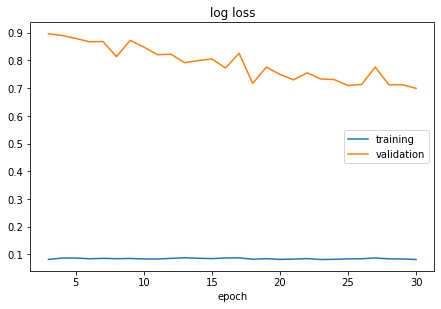

log loss:
training   (min:    0.072, max:    0.145, cur:    0.081)
validation (min:    0.699, max:    0.896, cur:    0.699)


In [77]:
model = Model3()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

result_n = []
ite = 0
liveloss = PlotLosses()

for epoch in range(100):
    logs = {}
    train_loss = train(model, optimizer, criterion, train_x_data, train_VCL_data) #train model using training data loader
    logs['' + 'log loss'] = train_loss.item()
    #logs['' + 'accuracy'] = 0

    validation_loss = validate(model, criterion, val_x_data, val_VCL_data) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    #logs['val_' + 'accuracy'] = 0
    
    result_n.append(train_loss)
    if len(result_n) > 30 and abs(train_loss - result_n[-5]) < 0.01:
        break

    liveloss.update(logs)
    liveloss.draw() ## plote LiveLoss plot

In [78]:
model_save_name = 'net3VCL.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

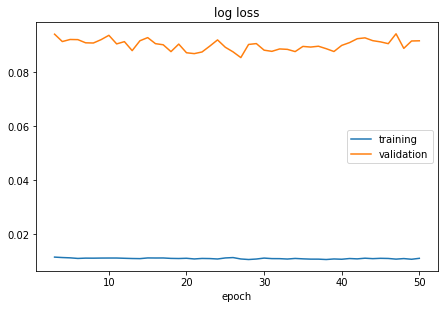

log loss:
training   (min:    0.011, max:    1.244, cur:    0.011)
validation (min:    0.085, max:    0.094, cur:    0.092)


In [79]:
model = Model3()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

result_n = []
ite = 0
liveloss = PlotLosses()

for epoch in range(100):
    logs = {}
    train_loss = train(model, optimizer, criterion, train_x_data, train_PHIE_data) #train model using training data loader
    logs['' + 'log loss'] = train_loss.item()
    #logs['' + 'accuracy'] = 0

    validation_loss = validate(model, criterion, val_x_data, val_PHIE_data) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    #logs['val_' + 'accuracy'] = 0
    
    result_n.append(train_loss)
    if len(result_n) > 50 and abs(train_loss - result_n[-5]) < 0.05:
        break

    liveloss.update(logs)
    liveloss.draw() ## plote LiveLoss plot

model_save_name = 'net3PHIE.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

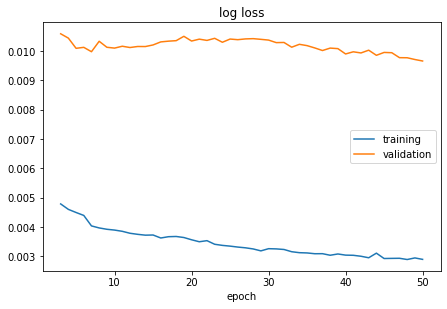

log loss:
training   (min:    0.003, max:    1.566, cur:    0.003)
validation (min:    0.010, max:    0.013, cur:    0.010)


In [80]:
model = Model3()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

result_n = []
ite = 0
liveloss = PlotLosses()

for epoch in range(100):
    logs = {}
    train_loss = train(model, optimizer, criterion, train_x_data, train_PHIT_data) #train model using training data loader
    logs['' + 'log loss'] = train_loss.item()
    #logs['' + 'accuracy'] = 0

    validation_loss = validate(model, criterion, val_x_data, val_PHIT_data) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    #logs['val_' + 'accuracy'] = 0
    
    result_n.append(train_loss)
    if len(result_n) > 50 and abs(train_loss - result_n[-5]) < 0.05:
        break

    liveloss.update(logs)
    liveloss.draw() ## plote LiveLoss plot

model_save_name = 'net3PHIT.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

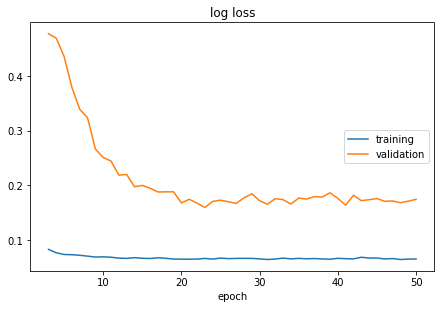

log loss:
training   (min:    0.064, max:    0.151, cur:    0.065)
validation (min:    0.159, max:    0.646, cur:    0.174)


In [81]:
model = Model3()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

result_n = []
ite = 0
liveloss = PlotLosses()

for epoch in range(100):
    logs = {}
    train_loss = train(model, optimizer, criterion, train_x_data, train_SW_data) #train model using training data loader
    logs['' + 'log loss'] = train_loss.item()
    #logs['' + 'accuracy'] = 0

    validation_loss = validate(model, criterion, val_x_data, val_SW_data) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    #logs['val_' + 'accuracy'] = 0
    
    result_n.append(train_loss)
    if len(result_n) > 50 and abs(train_loss - result_n[-5]) < 0.05:
        break

    liveloss.update(logs)
    liveloss.draw() ## plote LiveLoss plot

model_save_name = 'net3SW.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)

In [205]:
def train1(model, optimizer, criterion, x_train, y_train):
    model.train() # train model mode
    train_loss, train_accuracy = 0, 0 #instantiate return variables
    for i in range(len(x_train)): #iterate over data in batch size
        X, y = x_train[i].to(device), y_train[i].to(device)
        optimizer.zero_grad() #reset optimizer gradients
        a2 = model(X.view(-1, 6).to(device)) # predict for current data the model(x) value
        loss = criterion(a2, y.float()) #compute the loss by computing the criterion(y_prediction, y_real)
        loss.backward()  #perform backpropagation
        train_loss += loss*X.size(0) # keep track of loss
        y_pred = F.log_softmax(a2, dim = 1).max(1)[1] # apply softmax layer to prediction
        train_accuracy += accuracy_score(np.array([y.cpu().numpy()]), y_pred.detach().cpu().numpy())*X.size(0) # check for accuracy
        
        optimizer.step()  # step on gradient descent 
        
    return train_loss/len(x_train), train_accuracy/len(x_train)


def validate1(model, criterion, x_val, y_val):
    model.eval() #model evaluation
    validation_loss, validation_accuracy = 0., 0.
    for i in range(len(x_val)):
        with torch.no_grad(): # no optimisierr or stepping
            X, y = x_val[i].to(device), y_val[i].to(device)
            a2 = model(X.view(-1,6)).to(device) # predict for current data the model(x) value
            loss = criterion(a2, y.float()) #compute the loss by computing the criterion(y_prediction, y_real)
            validation_loss += loss*X.size(0)# keep track of loss
            y_pred = F.log_softmax(a2, dim=1).max(1)[1] # apply softmax layer to prediction
            validation_accuracy += accuracy_score(np.array([y.cpu().numpy()]), y_pred.cpu().numpy())*X.size(0) # check and track accuracy
            
    return validation_loss/len(x_val), validation_accuracy/len(x_val)

In [206]:
print(train_PERFO_data)

tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.int32)


In [207]:
class Model4(nn.Module):
    def __init__(self):
        super(Model4,self).__init__()
        self.l1 = nn.Linear(6,4)
        
        self.l2 = nn.Linear(4,2)
        #self.bn2 = nn.BatchNorm1d(2)

        self.activation = nn.ReLU() # ReLU activation after each active layer
        
    def forward(self,x):
        x = self.activation(self.l1(x)) #self.bn1(self.l1(x))
       
        y_pred = self.l2(x)
        return y_pred

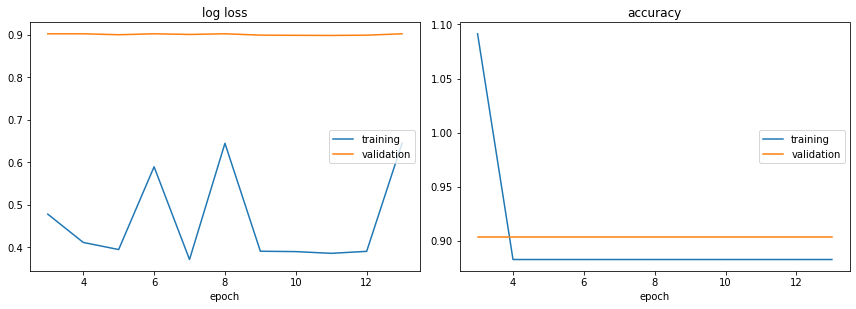

log loss:
training   (min:    0.371, max:   12.128, cur:    0.645)
validation (min:    0.898, max:    0.902, cur:    0.902)

accuracy:
training   (min:    0.883, max:    2.674, cur:    0.883)
validation (min:    0.903, max:    0.903, cur:    0.903)


KeyboardInterrupt: 

In [208]:
model = Model4()

criterion = nn.MSELoss(size_average = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-8)

result_n = []
ite = 0
liveloss = PlotLosses()

for epoch in range(100):
    logs = {}
    train_loss, train_accuracy = train1(model, optimizer, criterion, train_x_data, train_PERFO_data) #train model using training data loader
    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy= validate1(model, criterion, val_x_data, val_PERFO_data) # validate model using validation data loader
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()
    
    result_n.append(train_loss)
    if len(result_n) > 50 and abs(train_loss - result_n[-5]) < 0.05:
        break

    liveloss.update(logs)
    liveloss.draw() ## plote LiveLoss plot

model_save_name = 'net3PERFO.pt'
path = F'/home/chen/Downloads/{model_save_name}'
torch.save(model.state_dict(), path)